In [1]:
import torch, re
import torch.utils.data as data_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [92]:
def load_data(tokenizer):
    ds = []
    # Read from src
    with open('data/train_set.fasta') as f:
        lines = f.read().split(">")[1:]
        ds = [0]*len(lines)
        for i, line in enumerate(tqdm(lines)):
            seq, sep = line.strip().split("\n")[1:]
            seq = " ".join(seq)
            sep = re.sub("S|T|L|P", "0", sep) # simplify to SP existance
            sep = re.sub("I|M|O",   "1", sep) # simplify to SP non-existance
            sep = 1. if "0" in sep else 0.
            ds[i] = {
                'seq': seq,
                'sep': sep
            }
    # Tokenize data
    ds = [dict(item, **{'tokenized':tokenizer(item['seq'], padding='max_length', max_length=72, return_tensors="pt")}) for item in ds]
    return ds

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
ds = load_data(tokenizer)
ds = ds[-9443:]

100%|██████████| 20290/20290 [00:00<00:00, 87445.35it/s]


In [94]:
set([d['tokenized']['input_ids'].shape for d in ds])

{torch.Size([1, 72])}

In [95]:
for i in range(len(ds)): 
    ds[i]['tokenized'] = {k: v.flatten().to(device) 
        for k,v in ds[i]['tokenized'].items()}

In [96]:
ds[0]['tokenized']

{'input_ids': tensor([ 2, 21, 12,  6,  8, 11, 15,  5,  5, 19,  5,  6, 23, 11,  5,  8,  8, 15,
         20,  7, 14,  5, 11, 23,  7, 15, 17, 20, 23, 12, 14, 22, 16, 23, 15, 10,
         16, 11,  6, 13,  6, 10, 23, 13, 10, 16,  6, 15, 20, 13,  6, 17, 22, 10,
          7, 12, 23,  6, 23, 23, 16,  6, 23,  8, 15,  5,  5, 13,  9, 13,  6,  3]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [97]:
len(list(filter(lambda x : x['sep'] == 1, ds))) / len(ds)

0.494016731970772

In [98]:
model = model.to(device)
# ds = [dict(item, **{'tokenized':item['tokenized'].to(device)}) for item in ds]

In [108]:
dataset = data_utils.DataLoader(ds, batch_size=4)
tokens = next(iter(dataset))['tokenized']#.squeeze(1)
tokens['input_ids'].shape

torch.Size([4, 72])

In [109]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.functional.binary_cross_entropy
epochs = 1

In [110]:
set([d['tokenized']['input_ids'].shape for d in ds])

{torch.Size([72])}

In [111]:
loss_log = []
for epoch in range(epochs):
    loss = 0
    for i, batch in enumerate(tqdm(dataset)):
        optimizer.zero_grad()
        logits = model.forward(**batch['tokenized']).logits
        # pred = torch.nn.functional.softmax(logits, dim=1)
        y_pred = torch.argmax(logits, dim=1).double().requires_grad_()

        loss = criterion(y_pred, batch['sep'])
        loss.backward()
        optimizer.step()
        loss_log.append(loss.cpu().detach().item())
        if (i+1) % 10 == 0:
            print(loss.item())

  0%|          | 10/2361 [00:15<58:39,  1.50s/it] 

100.0


  1%|          | 20/2361 [00:30<1:02:35,  1.60s/it]

100.0


  1%|▏         | 30/2361 [00:50<1:14:31,  1.92s/it]

100.0


  2%|▏         | 40/2361 [01:05<1:01:16,  1.58s/it]

100.0


  2%|▏         | 50/2361 [01:20<57:22,  1.49s/it]  

100.0


  3%|▎         | 60/2361 [01:35<1:04:21,  1.68s/it]

100.0


  3%|▎         | 70/2361 [01:56<1:02:00,  1.62s/it]

100.0


  3%|▎         | 80/2361 [02:12<1:01:54,  1.63s/it]

100.0


  4%|▍         | 90/2361 [02:27<54:49,  1.45s/it]  

100.0


  4%|▍         | 100/2361 [02:41<50:23,  1.34s/it]

100.0


  5%|▍         | 110/2361 [02:55<57:04,  1.52s/it]

100.0


  5%|▌         | 120/2361 [03:10<56:33,  1.51s/it]

100.0


  5%|▌         | 120/2361 [03:10<59:17,  1.59s/it]


KeyboardInterrupt: 

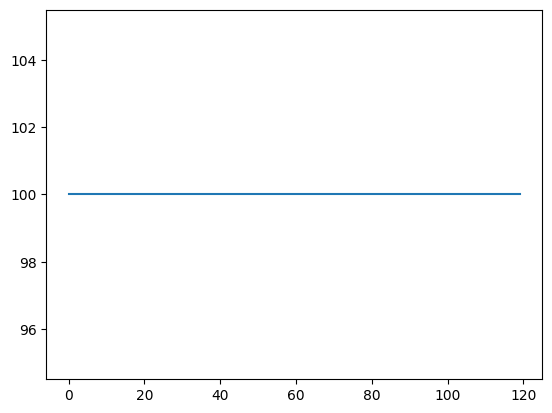

In [112]:
plt.plot(loss_log)

In [115]:
test = list("MDLSTKKVISAGLVFIYALSLAMLVPMFLASNQGVISAVINPATGGNCLPGRYSGIVQASGVTLPAVNLS")
test_label = "SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO"
test_label = re.sub("S|T|L|P", "0", test_label)
test_label = re.sub("I|M|O",   "1", test_label)
test_label = [float(t) for t in test_label]
ids = tokenizer(test, return_tensors="pt").to("cuda")
p = model.forward(**ids).logits
label = torch.argmax(p, dim=1)
print(f"{''.join(test)}\n{''.join([str(int(t)) for t in test_label])}\n{''.join([str(l) for l in label.cpu().numpy()])}")

MDLSTKKVISAGLVFIYALSLAMLVPMFLASNQGVISAVINPATGGNCLPGRYSGIVQASGVTLPAVNLS
0000000000000000000000000000001111111111111111111111111111111111111111
1111111111111111111111111111111111111111111111111111111111111111111111


In [84]:
len(list(filter(lambda x: not all(x['sep'] == torch.ones(len(x['sep'])).numpy()), ds[-9443:])))

4665

20290

In [31]:
torch.ones(len(ds[3000]['sep'])).numpy() == [1.]*len(ds[3000]['sep'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
num_epochs = 1
logging_steps = 100

training_args = TrainingArguments(output_dir="./outputs/" + "sp_bert",
                                    logging_dir="./logs",
                                    logging_steps=logging_steps,
                                    logging_first_step=True,
                                    evaluation_strategy="steps",
                                    save_strategy='epoch',
                                    optim='adamw_torch',
                                    num_train_epochs=num_epochs,
                                    auto_find_batch_size=True,
                                    )
trainer = Trainer(
    model=model,
    tokenizer=self.tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=self.__compute_metrics,
)